## Introduction

Siamese networks are a class of neural networks specifically designed to learn and recognize similarities between inputs. They have found wide applications in tasks like signature verification, face recognition, and image similarity comparison.

In this project, I aim to develop a Siamese network tailored for face recognition. Face recognition is a fundamental aspect of computer vision with applications ranging from security systems to social media platforms. By leveraging the capabilities of Siamese networks along with MobileNetV2, a state-of-the-art convolutional neural network architecture, and face landmarks, I aim to create a robust model capable of accurately recognizing and comparing faces.


### Model Architecture

The foundation of my Siamese network model lies in the construction of an embedding model. This model serves as the feature extractor and is responsible for extracting meaningful representations from input images and corresponding face landmarks. MobileNetV2, known for its efficiency and effectiveness in image classification tasks, forms the backbone of the embedding model. By utilizing transfer learning, I leverage the pre-trained MobileNetV2 model to extract high-level features from input images.

In addition to input images, my model also takes face landmarks as input. These landmarks provide valuable spatial information about key facial features, enhancing the model's ability to recognize and compare faces accurately. The extracted features from both images and landmarks are processed through custom layers, including global average pooling and dense layers with LeakyReLU activation, to further enhance the representation.

The Siamese network architecture is then constructed to compute distances between the embeddings extracted by the embedding model. A custom distance layer calculates the cosine similarity between the anchor and positive embeddings, as well as between the anchor and negative embeddings. This allows the model to learn to differentiate between similar and dissimilar instances.


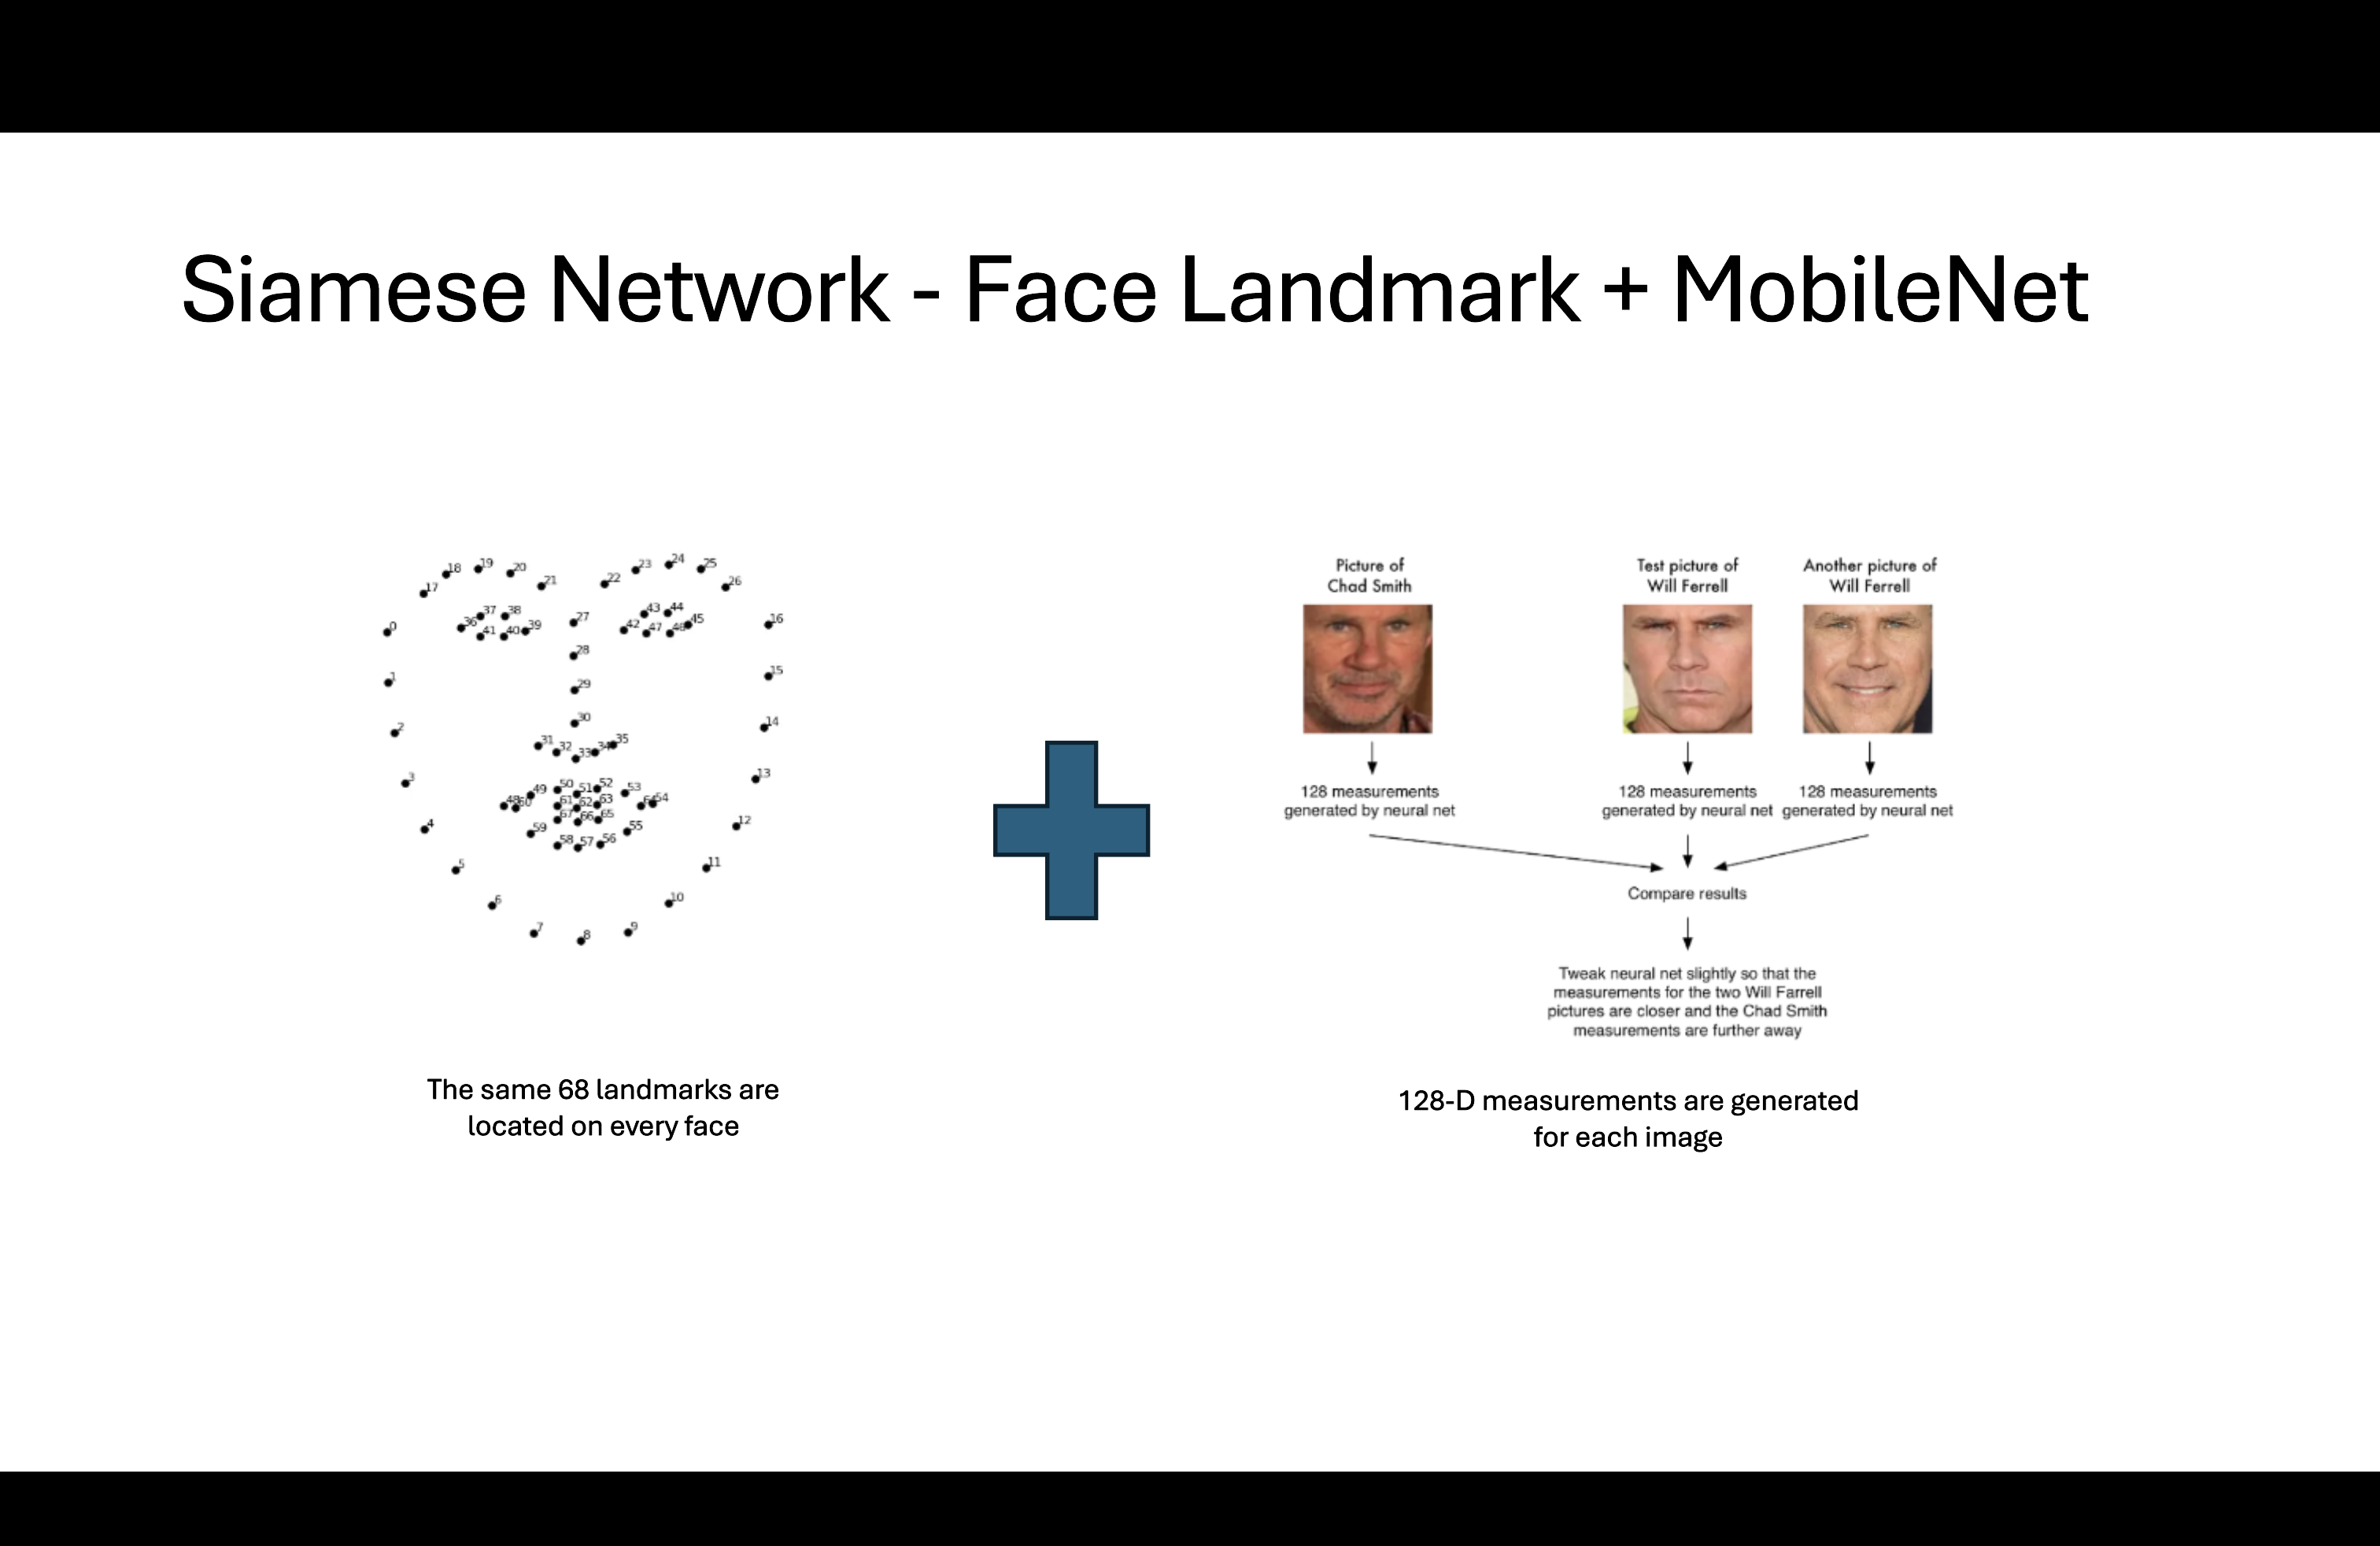

### Model Implementation and Training

To implement the Siamese network model, I define a custom SiameseModel class, which encapsulates the training, evaluation, and inference logic. The model is trained using triplet loss, where the goal is to minimize the distance between anchor and positive embeddings while maximizing the distance between anchor and negative embeddings by a predefined margin. During training, the model learns to map similar instances closer in the embedding space while pushing dissimilar instances farther apart.

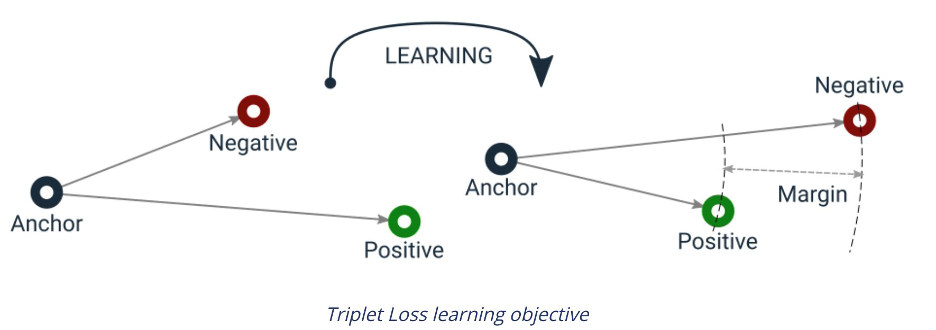

The model is trained on unsupervised dataset where different images of the same person will form the anchor and positive image dataset pair and dissimilar person image will form anchor and negative image. Thus, (anchor, positive, negative) image dataset will be formed which will be used to train the model by using triplet loss function.

To evaluate the model's performance, I track metric such as loss and distances between embeddings during both training and evaluation. By fine-tuning the model on suitable datasets and optimizing hyperparameters, I aim to achieve state-of-the-art performance in face recognition and image similarity tasks.

In [2]:
!pip install dlib

DEPRECATION: Loading egg at /Users/vignesh/anaconda3/lib/python3.11/site-packages/meilisearch-0.21.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at /Users/vignesh/anaconda3/lib/python3.11/site-packages/pydantic-1.10.8-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at /Users/vignesh/anaconda3/lib/python3.11/site-packages/portalocker-2.7.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at /Users/vignesh/anaconda3/lib/python3.11/site-packages/loguru-0.6.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at /Users/vignesh/anaconda3/lib/python3.1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pandas as pd
import tensorflow as tf
from pathlib import Path
from keras import applications, layers, losses, ops, optimizers, metrics, Model, Sequential
from keras.applications import MobileNetV2
import cv2
from tqdm.auto import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import AutoImageProcessor, AutoModel
from transformers import TFAutoModel

from PIL import Image
import requests

import time

from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, Distance
from qdrant_client.models import PointStruct
import glob
import random
from functools import lru_cache
import tensorflow_io as tfio

import dlib
import numpy as np
from tensorflow.keras import models, layers
import cv2
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
import math 

In [16]:
channels = 3
img_height, img_width = 224, 224
input_shape = (img_height, img_width) + (channels,)
print(input_shape)

(224, 224, 3)


In [17]:
num_landmarks = 68
input_shape_landmark=(num_landmarks, 2)

## Preprocessing image and its landmarks

### Landmarks extraction in face

In [3]:
def load_dlib_landmark_detector():
    # Load the pre-trained facial landmark detector model from DLIB
    landmark_detector = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    return landmark_detector

landmark_detector = load_dlib_landmark_detector()

In [4]:

def extract_landmarks(image_path, landmark_detector):
    # Convert the image to grayscale (DLIB expects grayscale images)
    image = cv2.imread(image_path)
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect facial landmarks using the loaded landmark detector
    faces = dlib.rectangle(0, 0, image.shape[1], image.shape[0])  # Assume the whole image is a face
    landmarks = landmark_detector(gray_image, faces)
    
    # Extract landmark coordinates
    landmark_points = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(68)])

    return landmark_points


### Loading and Process Image triplets

The (anchor, positive and negative image) pairs are prepared and created as a triplet.csv in a seperate notebook(Data preparation notebook attached).The total dataset contains ***53758 images*** including Data augmentation. 

In [10]:
triplets = pd.read_csv("triplets.csv")

In [11]:
triplets.head()

,anchor,positive,negative,anchor_names
0,/Users/vignesh/Documents/george brown pgdm /DL...,/Users/vignesh/Documents/george brown pgdm /DL...,/Users/vignesh/Documents/george brown pgdm /DL...,1.png
1,/Users/vignesh/Documents/george brown pgdm /DL...,/Users/vignesh/Documents/george brown pgdm /DL...,/Users/vignesh/Documents/george brown pgdm /DL...,10.png
2,/Users/vignesh/Documents/george brown pgdm /DL...,/Users/vignesh/Documents/george brown pgdm /DL...,/Users/vignesh/Documents/george brown pgdm /DL...,10_aug_1.jpg
3,/Users/vignesh/Documents/george brown pgdm /DL...,/Users/vignesh/Documents/george brown pgdm /DL...,/Users/vignesh/Documents/george brown pgdm /DL...,10_aug_2.jpg
4,/Users/vignesh/Documents/george brown pgdm /DL...,/Users/vignesh/Documents/george brown pgdm /DL...,/Users/vignesh/Documents/george brown pgdm /DL...,10_aug_3.jpg


In [7]:
triplet_anchor_landmarks = {}

for anchor in tqdm(triplets["anchor"]):
    triplet_anchor_landmarks[anchor] = extract_landmarks(anchor, landmark_detector)

  0%|          | 0/53758 [00:00<?, ?it/s]

In [8]:
triplets["anchor_landmarks"] = triplets["anchor"].apply(lambda anchor: triplet_anchor_landmarks[anchor])

In [9]:

for positive in tqdm(triplets["positive"]):
    
    if triplet_anchor_landmarks.get(positive, None) is not None:        
        triplet_anchor_landmarks[positive] = extract_landmarks(positive, landmark_detector)

  0%|          | 0/53758 [00:00<?, ?it/s]

In [10]:
triplets["positive_landmarks"] = triplets["positive"].apply(lambda positive: triplet_anchor_landmarks[positive])

In [11]:

for negative in tqdm(triplets["negative"]):
    
    if triplet_anchor_landmarks.get(negative, None) is not None:        
        triplet_anchor_landmarks[negative] = extract_landmarks(negative, landmark_detector)

  0%|          | 0/53758 [00:00<?, ?it/s]

In [12]:
triplets["negative_landmarks"] = triplets["negative"].apply(lambda negative: triplet_anchor_landmarks[negative])

In [13]:
triplets.dtypes

anchor                object
positive              object
negative              object
anchor_names          object
anchor_landmarks      object
positive_landmarks    object
negative_landmarks    object
dtype: object

In [13]:
triplet_count = len(triplets)
print(triplet_count)

53758


In [22]:
def preprocess_image(image_path):
    
    
    image_string = tf.io.read_file(image_path)
    
    if tf.strings.split(image_path, sep=".")[-1] == "png":
        image = tf.image.decode_png(image_string)
    else:
        image = tf.image.decode_jpeg(image_string)

            # Convert image to grayscale
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image) # to get 3 channels

    
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (img_height, img_width), method=tf.image.ResizeMethod.AREA)
    
    return tf.keras.applications.mobilenet_v2.preprocess_input(image)


In [24]:
def preprocess_landmarks(anchor_landmarks, positive_landmarks, negative_landmarks):
    return (tf.convert_to_tensor((anchor_landmarks / img_width, img_height)[0]), 
                tf.convert_to_tensor((positive_landmarks / img_width, img_height)[0]),
                    tf.convert_to_tensor((negative_landmarks / img_width, img_height)[0]))
                    

In [25]:
def preprocess_triplets(anchor_path, positive_path, negative_path, anchor_landmarks, positive_landmarks, negative_landmarks):
    """
    Given the filenames corresponding to the three images and their landmarks,
    load and preprocess them.
    """

    return (tf.stack([preprocess_image(anchor_path),
                     preprocess_image(positive_path),
                     preprocess_image(negative_path)]),
            tf.stack(preprocess_landmarks(anchor_landmarks,
                                          positive_landmarks,
                                          negative_landmarks)))



In [28]:
anchor_paths = triplets["anchor"]
positive_paths = triplets["positive"]
negative_paths = triplets["negative"]
anchor_landmarks = triplets["anchor_landmarks"].to_list()
positive_landmarks = triplets["positive_landmarks"].to_list()
negative_landmarks = triplets["negative_landmarks"].to_list()

# Create dataset with images and landmark coordinates
dataset = tf.data.Dataset.from_tensor_slices((
    anchor_paths, positive_paths, negative_paths,
    anchor_landmarks, positive_landmarks, negative_landmarks
))

# Shuffle and preprocess the dataset
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Split the dataset into training and validation sets
train_dataset = dataset.take(round(triplet_count * 0.8))
val_dataset = dataset.skip(round(triplet_count * 0.8))

# Batch and prefetch the datasets
train_dataset = train_dataset.batch(64, drop_remainder=False).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32, drop_remainder=False).prefetch(tf.data.AUTOTUNE)


### Example Shape of inputs

In [29]:
for i in train_dataset:
    print("Image Input", i[0].shape)
    print("Landmarks Input", i[1].shape)

    break

(64, 3, 224, 224, 3) (64, 3, 68, 2)


## Model Building

### Embedding Model by keeping Mobilenet as a base CNN

In [4]:
def construct_embedding_model():
    
    """
    Constructs an embedding model that combines image and landmark inputs to generate embeddings.

    Returns:
        model (tf.keras.Model): A Keras Model object representing the embedding model.

    Raises:
        None

    Example usage:
        embedding_model = construct_embedding_model()
    """
    # Input for the image
    image_input = layers.Input(shape=input_shape, name='image_input')
    
    # Load the pre-trained MobileNetV2 model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze some layers of the base MobileNetV2 model
    for layer in base_model.layers[:-5]:
        layer.trainable = False

    # Add custom layers for image feature extraction
    image_features = base_model(image_input)
    image_features = layers.GlobalAveragePooling2D()(image_features)
    image_features = layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.5))(image_features)

    # Input for the landmarks
    landmark_input = layers.Input(shape=input_shape_landmark, name='landmark_input')

    # Flatten the landmark input
    flattened_landmarks = layers.Flatten()(landmark_input)
    landmark_features = layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.1))(flattened_landmarks)

    # Concatenate image features and landmark features
    concatenated_features = layers.concatenate([image_features, landmark_features])

    # Additional dense layers for embedding generation
    embedding_output = layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.5), name='embedding_output')(concatenated_features)

    # Define the model with both image and landmark inputs
    model = models.Model(inputs=[image_input, landmark_input], outputs=embedding_output, name='Embedding_Model')

    return model

### Cosine Similarity based Distance Layer

In [19]:
    
class DistanceLayer(layers.Layer):
    """
    Custom Keras layer to compute distances between embeddings.

    This layer computes the cosine similarity between the anchor and positive embeddings,
    as well as the cosine similarity between the anchor and negative embeddings.

    Args:
        None

    Returns:
        tuple: A tuple containing the cosine similarity between anchor and positive embeddings
               and the cosine similarity between anchor and negative embeddings.

    Raises:
        None

    Example usage:
        distance_layer = DistanceLayer()
        ap_distance, an_distance = distance_layer(anchor_embedding, positive_embedding, negative_embedding)
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        eps = 1e-8  # Small epsilon value to prevent division by zero
        anchor_norm = tf.norm(anchor, axis=-1) + eps
        positive_norm = tf.norm(positive, axis=-1) + eps
        negative_norm = tf.norm(negative, axis=-1) + eps
        
        ap_distance = tf.reduce_sum(anchor * positive, axis=-1) / (anchor_norm * positive_norm)
        an_distance = tf.reduce_sum(anchor * negative, axis=-1) / (anchor_norm * negative_norm)
        
        return ap_distance, an_distance
    

### Siamese Network Model

In [7]:
def construct_siamese_network(embedding_model):
    
    """
    Constructs a Siamese network model.

    This function takes an embedding model and constructs a Siamese network model,
    which takes anchor, positive, and negative images along with their corresponding
    landmarks as inputs, extracts their embeddings using the given embedding model,
    and computes the distances between the embeddings.

    Args:
        embedding_model (tf.keras.Model): The embedding model to be used within the Siamese network.

    Returns:
        tuple: A tuple containing the constructed Siamese network model and the distance layer.

    Example usage:
        siamese_network, distances = construct_siamese_network(embedding_model)
    """
        
    # Inputs for anchor, positive, and negative images
    anchor_input = layers.Input(name="anchor", shape=input_shape)
    positive_input = layers.Input(name="positive", shape=input_shape)
    negative_input = layers.Input(name="negative", shape=input_shape)
    
    # Inputs for anchor, positive, and negative landmarks
    anchor_landmark_input = layers.Input(name="anchor_landmark", shape=(num_landmarks, 2))
    positive_landmark_input = layers.Input(name="positive_landmark", shape=(num_landmarks, 2))
    negative_landmark_input = layers.Input(name="negative_landmark", shape=(num_landmarks, 2))
    
    # Extract embeddings for anchor, positive, and negative images
    anchor_embedding = embedding_model([anchor_input, anchor_landmark_input])
    positive_embedding = embedding_model([positive_input, positive_landmark_input])
    negative_embedding = embedding_model([negative_input, negative_landmark_input])
    
    # Calculate distances between embeddings
    distances = DistanceLayer()(anchor_embedding, positive_embedding, negative_embedding)
    
    # Construct the Siamese network model
    siamese_network = Model(
        inputs=[anchor_input, positive_input, negative_input, anchor_landmark_input, positive_landmark_input, negative_landmark_input],
        outputs=distances,
        name="SiameseNetwork"
    )
    
    siamese_network.summary()
    
    return siamese_network, distances

### Siamese Network Trainer

In [21]:
class SiameseModel(Model):
    
    """
    Siamese model for training and evaluation of siamese network.

    This model takes triplets of anchor, positive, and negative examples,
    calculates their embeddings, and computes the distance between the anchor
    and positive embeddings as well as between the anchor and negative embeddings.

    Args:
        siamese_network (tf.keras.Model): The Siamese network model.
        margin (float): The margin value used in the triplet loss function.

    Returns:
        None

    Example usage:
        siamese_model = SiameseModel(siamese_network)
    """
    
    def __init__(self, siamese_network, margin=2):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        
        self.loss_tracker = metrics.Mean(name="loss")
        self.ap_distance_tracker = metrics.Mean(name="ap_distance")
        self.an_distance_tracker = metrics.Mean(name="an_distance")
        
        self.val_loss_tracker = metrics.Mean(name="vloss")
        self.val_ap_distance_tracker = metrics.Mean(name="vap_distance")
        self.val_an_distance_tracker = metrics.Mean(name="van_distance")


    def call(self, inputs):
        """
        Forward pass of the Siamese model.

        Args:
            inputs (tuple): A tuple containing the anchor, positive, and negative inputs.

        Returns:
            tuple: A tuple containing the distances between anchor and positive embeddings
                   and between anchor and negative embeddings.
        """
        return self.siamese_network(self._unstack(inputs))
        
        #this will be called in the fit method repeatedly. 
    def train_step(self, data):
        """
        Custom training step for the Siamese model.

        Args:
            data (tuple): A tuple containing the anchor, positive, and negative inputs.

        Returns:
            dict: A dictionary containing the loss and distance metrics for the training step.
        """
        with tf.GradientTape() as tape:
            ap_distance, an_distance = self.siamese_network(self._unstack(data))           
            loss = self._compute_loss(ap_distance, an_distance)
         
        # Fetching all the gradients of the model(siamese network)
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        
        # apply gradients after 
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )
        
        self.loss_tracker.update_state(loss)
        self.ap_distance_tracker.update_state(ap_distance)
        self.an_distance_tracker.update_state(an_distance)
        return {"loss": self.loss_tracker.result(), 
                   "ap_distance": self.ap_distance_tracker.result(), 
                   "an_distance": self.an_distance_tracker.result()}
            
            
    def _unstack(self, stacked_inputs):
        """
        Unstacks the stacked inputs into separate tensors.

        Args:
            stacked_inputs (tuple): A tuple of stacked input tensors.

        Returns:
            tuple: A tuple of unstacked input tensors.
        """
        feature_extractor_stacked_inputs = stacked_inputs[0]
        feature_extractor_inputs = tf.transpose(feature_extractor_stacked_inputs, perm=[1, 0, 2, 3, 4])
        
        landmark_stacked_inputs = stacked_inputs[1]
        landmark_inputs = tf.transpose(landmark_stacked_inputs, perm=[1, 0, 2, 3])

        return feature_extractor_inputs[0], feature_extractor_inputs[1], feature_extractor_inputs[2] , landmark_inputs[0],  landmark_inputs[1],  landmark_inputs[2]

    
    def _compute_loss(self, ap_distance, an_distance):
        """
        Computes the triplet loss.

        Args:
            ap_distance (tf.Tensor): The distance between anchor and positive embeddings.
            an_distance (tf.Tensor): The distance between anchor and negative embeddings.

        Returns:
            tf.Tensor: The computed loss.
        """
        loss = an_distance - ap_distance + self.margin
        loss = tf.maximum(loss, 0.0)
        return loss
    
    def test_step(self, data):
        """
        Custom evaluation step for the Siamese model.

        Args:
            data (tuple): A tuple containing the anchor, positive, and negative inputs.

        Returns:
            dict: A dictionary containing the loss and distance metrics for the evaluation step.
        """
        ap_distance, an_distance = self.siamese_network(self._unstack(data))
        loss = self._compute_loss(ap_distance, an_distance)
        
        self.val_loss_tracker.update_state(loss)
        self.val_ap_distance_tracker.update_state(ap_distance)
        self.val_an_distance_tracker.update_state(an_distance)
        
        return {"val_loss": self.val_loss_tracker.result(), 
                   "val_ap_distance": self.val_ap_distance_tracker.result(), 
                   "val_an_distance": self.val_an_distance_tracker.result()}
    
    
    def get_embedding(self):
        """
        Retrieves the embedding layer of the Siamese network.

        Args:
            None

        Returns:
            tf.keras.Model: The embedding layer of the Siamese network.
        """

        return self.siamese_network.get_layer("Embedding").layers
    
    @property
    def metrics(self):
        
        """
        Returns the list of metrics for tracking during training and evaluation.

        Args:
            None

        Returns:
            list: A list of metric objects.
        """
        return [self.loss_tracker, self.ap_distance_tracker, self.an_distance_tracker, 
               self.val_loss_tracker,   self.val_ap_distance_tracker, self.val_an_distance_tracker]


In [9]:
def build_siamese_model(weights=None):
    
    """
    Builds a Siamese model for training and evaluation.

    This function constructs a Siamese model by first creating an embedding model
    using the `construct_embedding_model` function, then using the embedding model
    to construct a Siamese network model with the `construct_siamese_network` function.
    Finally, it creates a SiameseModel object for training and evaluation.

    Args:
        weights (str): Optional. Path to the weights file to initialize the model.

    Returns:
        tuple: A tuple containing the constructed Siamese model, embedding model,
               and the distance layer.

    Example usage:
        siamese_model, embedding_model, distance_layer = build_siamese_model(weights='weights.h5')
    """
    
    embedding_model = construct_embedding_model()
    simese_network, distance_layer = construct_siamese_network(embedding_model)
    
    siamese_model = SiameseModel(simese_network)

    if weights:
        siamese_model.load_weights(weights)
    else:
        initial_learning_rate = 0.0001
        siamese_model.compile(optimizer=optimizers.Adam(initial_learning_rate))
    
    return siamese_model, embedding_model, distance_layer

In [33]:
siamese_model, embedding_mode, distance_layer = build_siamese_model()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer) │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anchor_landmark     │ (None, 68, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive_landmark   │ (None, 68, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative_landmark   │ (None, 68, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding_Model     │ (None, 256)       │  3,070,336 │ anchor[0][0],     │
│ (Functional)        │                   │            │ anchor_landmark[… │
│                     │                   │            │ positive[0][0],   │
│                     │                   │            │ positive_landmar… │
│                     │                   │            │ negative[0][0],   │
│                     │                   │            │ negative_landmar… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance_layer_1    │ [(None), (None)]  │          0 │ Embedding_Model[… │
│ (DistanceLayer)     │                   │            │ Embedding_Model[… │
│                     │                   │            │ Embedding_Model[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,070,336 (11.71 MB)

 Trainable params: 1,532,352 (5.85 MB)

 Non-trainable params: 1,537,984 (5.87 MB)

In [34]:

def cyclic_learning_rate(epoch, learning_rate_max=0.001, learning_rate_min=0.0001, step_size=672):
    # Calculate the learning rate based on the cyclic learning rate schedule
    cycle = math.floor(1 + epoch / (2 * step_size))
    x = abs(epoch / step_size - 2 * cycle + 1)
    learning_rate = learning_rate_min + (learning_rate_max - learning_rate_min) * max(0, 1 - x)
    return learning_rate

step_size = int(672/2)  # Number of steps per half cycle
lr_scheduler_callback = LearningRateScheduler(lambda epoch: cyclic_learning_rate(epoch, learning_rate_max=0.001, learning_rate_min=0.0001, step_size=step_size))

checkpoint_callback =  ModelCheckpoint(filepath="./siaseme_models/mobilenet/siamese_network_mobilenet.keras",
      save_best_only=True, monitor="val_vloss")

callbacks = [lr_scheduler_callback, checkpoint_callback]

In [35]:
history = siamese_model.fit(train_dataset, epochs=5, validation_data=val_dataset, callbacks=callbacks)


Epoch 1/5


2024-03-28 14:40:59.761431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


672/672 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - an_distance: 0.4678 - ap_distance: 0.6480 - loss: 1.8199

/Users/vignesh/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


672/672 ━━━━━━━━━━━━━━━━━━━━ 1188s 2s/step - an_distance: 0.4677 - ap_distance: 0.6479 - loss: 1.8198 - van_distance: 0.0000e+00 - vap_distance: 0.0000e+00 - vloss: 0.0000e+00 - val_an_distance: 0.0000e+00 - val_ap_distance: 0.0000e+00 - val_loss: 0.0000e+00 - val_van_distance: 0.3634 - val_vap_distance: 0.5958 - val_vloss: 1.7676
Epoch 2/5
672/672 ━━━━━━━━━━━━━━━━━━━━ 299s 445ms/step - an_distance: 0.3140 - ap_distance: 0.5535 - loss: 1.7605 - van_distance: 0.0000e+00 - vap_distance: 0.0000e+00 - vloss: 0.0000e+00 - val_an_distance: 0.0000e+00 - val_ap_distance: 0.0000e+00 - val_loss: 0.0000e+00 - val_van_distance: 0.3337 - val_vap_distance: 0.5752 - val_vloss: 1.7584
Epoch 3/5
672/672 ━━━━━━━━━━━━━━━━━━━━ 312s 464ms/step - an_distance: 0.2771 - ap_distance: 0.5281 - loss: 1.7489 - van_distance: 0.0000e+00 - vap_distance: 0.0000e+00 - vloss: 0.0000e+00 - val_an_distance: 0.0000e+00 - val_ap_distance: 0.0000e+00 - val_loss: 0.0000e+00 - val_van_distance: 0.2537 - val_vap_distance: 0.51

In [63]:
def plot_with_history(history, title):

    plt.plot(history.history['loss'], label = 'loss')
    plt.plot(history.history['val_vloss'], label = 'val_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')
    plt.title(title)
    plt.show()

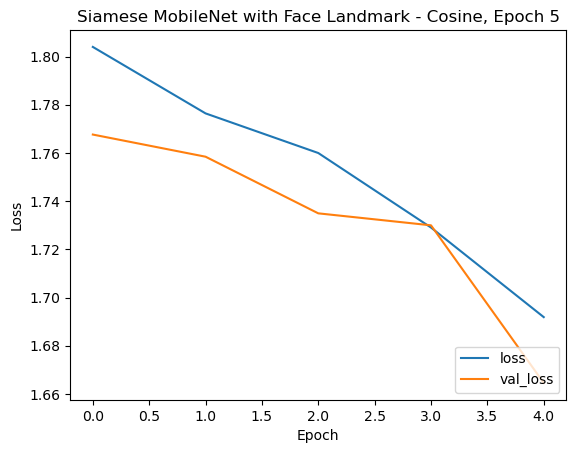

In [64]:
plot_with_history(history, "Siamese MobileNet with Face Landmark - Cosine, Epoch 5")

In [37]:
history10 = siamese_model.fit(train_dataset, epochs=5, validation_data=val_dataset, callbacks=[callbacks, lr_scheduler])


Epoch 1/5
672/672 ━━━━━━━━━━━━━━━━━━━━ 300s 445ms/step - an_distance: 0.1062 - ap_distance: 0.4444 - loss: 1.6618 - van_distance: 0.0000e+00 - vap_distance: 0.0000e+00 - vloss: 0.0000e+00 - val_an_distance: 0.0000e+00 - val_ap_distance: 0.0000e+00 - val_loss: 0.0000e+00 - val_van_distance: 0.1234 - val_vap_distance: 0.4677 - val_vloss: 1.6557 - learning_rate: 1.0000e-04
Epoch 2/5
672/672 ━━━━━━━━━━━━━━━━━━━━ 299s 444ms/step - an_distance: 0.0748 - ap_distance: 0.4423 - loss: 1.6325 - van_distance: 0.0000e+00 - vap_distance: 0.0000e+00 - vloss: 0.0000e+00 - val_an_distance: 0.0000e+00 - val_ap_distance: 0.0000e+00 - val_loss: 0.0000e+00 - val_van_distance: 0.1012 - val_vap_distance: 0.4601 - val_vloss: 1.6412 - learning_rate: 1.0268e-04
Epoch 3/5
672/672 ━━━━━━━━━━━━━━━━━━━━ 303s 451ms/step - an_distance: 0.0587 - ap_distance: 0.4418 - loss: 1.6170 - van_distance: 0.0000e+00 - vap_distance: 0.0000e+00 - vloss: 0.0000e+00 - val_an_distance: 0.0000e+00 - val_ap_distance: 0.0000e+00 - val_

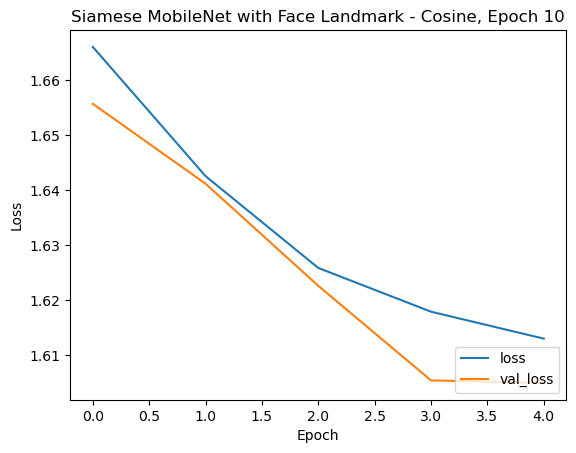

In [65]:
plot_with_history(history10, "Siamese MobileNet with Face Landmark - Cosine, Epoch 10")

***Over the course of training, my Siamese network model demonstrated consistent improvement in performance. The model's training and validation losses decreased steadily across epochs, indicating effective learning. Additionally, the distances between anchor and positive embeddings decreased while the distances between anchor and negative embeddings increased, as intended by the triplet loss function. This suggests that the model successfully learned to map similar instances closer together and dissimilar instances farther apart in the embedding space. Overall, the training logs reflect the model's ability to effectively learn and differentiate between similar and dissimilar instances, leading to improved face recognition and image similarity performance.***

In [43]:
history15 = siamese_model.fit(train_dataset, epochs=5, validation_data=val_dataset, callbacks=[callbacks, lr_scheduler])

Epoch 1/5
672/672 ━━━━━━━━━━━━━━━━━━━━ 299s 443ms/step - an_distance: 0.0388 - ap_distance: 0.4427 - loss: 1.5962 - van_distance: 0.0000e+00 - vap_distance: 0.0000e+00 - vloss: 0.0000e+00 - val_an_distance: 0.0000e+00 - val_ap_distance: 0.0000e+00 - val_loss: 0.0000e+00 - val_van_distance: 0.0274 - val_vap_distance: 0.4337 - val_vloss: 1.5937 - learning_rate: 1.0000e-04
Epoch 2/5
672/672 ━━━━━━━━━━━━━━━━━━━━ 299s 445ms/step - an_distance: 0.0341 - ap_distance: 0.4451 - loss: 1.5890 - van_distance: 0.0000e+00 - vap_distance: 0.0000e+00 - vloss: 0.0000e+00 - val_an_distance: 0.0000e+00 - val_ap_distance: 0.0000e+00 - val_loss: 0.0000e+00 - val_van_distance: 0.0548 - val_vap_distance: 0.4502 - val_vloss: 1.6046 - learning_rate: 1.0268e-04
Epoch 3/5
672/672 ━━━━━━━━━━━━━━━━━━━━ 299s 443ms/step - an_distance: 0.0801 - ap_distance: 0.4703 - loss: 1.6098 - van_distance: 0.0000e+00 - vap_distance: 0.0000e+00 - vloss: 0.0000e+00 - val_an_distance: 0.0000e+00 - val_ap_distance: 0.0000e+00 - val_

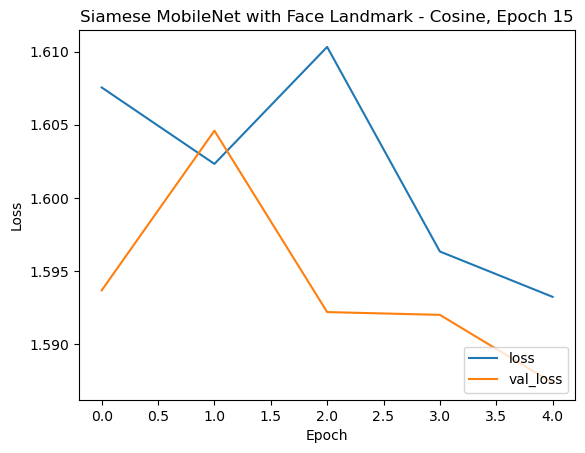

In [66]:
plot_with_history(history15, "Siamese MobileNet with Face Landmark - Cosine, Epoch 15")

In [67]:
history20 = siamese_model.fit(train_dataset, epochs=5, validation_data=val_dataset, callbacks=[callbacks, lr_scheduler])

Epoch 1/5
672/672 ━━━━━━━━━━━━━━━━━━━━ 305s 452ms/step - an_distance: 0.0314 - ap_distance: 0.4507 - loss: 1.5807 - van_distance: 0.0000e+00 - vap_distance: 0.0000e+00 - vloss: 0.0000e+00 - val_an_distance: 0.0000e+00 - val_ap_distance: 0.0000e+00 - val_loss: 0.0000e+00 - val_van_distance: 0.0158 - val_vap_distance: 0.4430 - val_vloss: 1.5728 - learning_rate: 1.0000e-04
Epoch 2/5
672/672 ━━━━━━━━━━━━━━━━━━━━ 302s 448ms/step - an_distance: 0.0337 - ap_distance: 0.4577 - loss: 1.5760 - van_distance: 0.0000e+00 - vap_distance: 0.0000e+00 - vloss: 0.0000e+00 - val_an_distance: 0.0000e+00 - val_ap_distance: 0.0000e+00 - val_loss: 0.0000e+00 - val_van_distance: 0.0198 - val_vap_distance: 0.4436 - val_vloss: 1.5763 - learning_rate: 1.0268e-04
Epoch 3/5
672/672 ━━━━━━━━━━━━━━━━━━━━ 301s 447ms/step - an_distance: 0.0288 - ap_distance: 0.4514 - loss: 1.5775 - van_distance: 0.0000e+00 - vap_distance: 0.0000e+00 - vloss: 0.0000e+00 - val_an_distance: 0.0000e+00 - val_ap_distance: 0.0000e+00 - val_

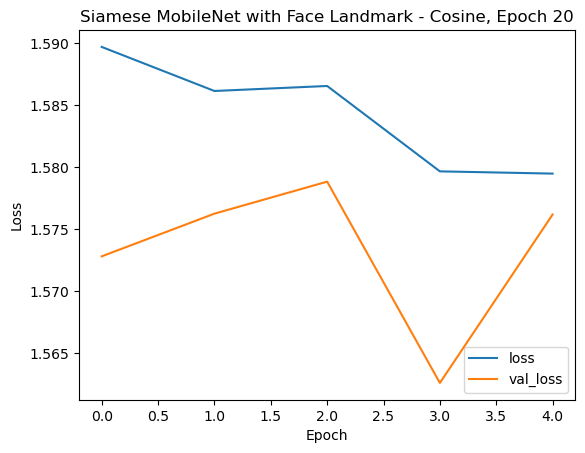

In [68]:
plot_with_history(history20, "Siamese MobileNet with Face Landmark - Cosine, Epoch 20")

Over the last ten epochs, while the model continued to show improvement initially, there was a noticeable change in behavior towards the end. Despite the initial decrease in loss and improvement in distance metrics, the model's performance seemed to plateau, and in some cases, the loss even started to increase slightly. This could indicate that the model might be overfitting to the training data or encountering difficulties in generalizing to unseen instances. Further analysis and possibly adjustments to the model architecture or training strategy may be needed to address this issue and ensure continued performance improvement.








### Inference

The inference code extracts embeddings for anchor, positive, and negative instances, computing distances between them using the trained Siamese network. Visualizing the distances between positive and negative instances reveals the model's capability to discriminate between them. 

In [14]:
model_path = "./siaseme_models/mobilenet-marker-v2-256-Epoch20-1711662012369580000.weights.h5"

In [22]:
siamese_model, trained_embeddings_model, distance_layer = build_siamese_model(model_path)

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer) │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anchor_landmark     │ (None, 68, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive_landmark   │ (None, 68, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative_landmark   │ (None, 68, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding_Model     │ (None, 256)       │  3,070,336 │ anchor[0][0],     │
│ (Functional)        │                   │            │ anchor_landmark[… │
│                     │                   │            │ positive[0][0],   │
│                     │                   │            │ positive_landmar… │
│                     │                   │            │ negative[0][0],   │
│                     │                   │            │ negative_landmar… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance_layer_1    │ [(None), (None)]  │          0 │ Embedding_Model[… │
│ (DistanceLayer)     │                   │            │ Embedding_Model[… │
│                     │                   │            │ Embedding_Model[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,070,336 (11.71 MB)

 Trainable params: 1,532,352 (5.85 MB)

 Non-trainable params: 1,537,984 (5.87 MB)

In [79]:
            
def unstack(stacked_inputs):
    feature_extractor_stacked_inputs = stacked_inputs[0]
    feature_extractor_inputs = tf.transpose(feature_extractor_stacked_inputs, perm=[1, 0, 2, 3, 4])

    landmark_stacked_inputs = stacked_inputs[1]
    landmark_inputs = tf.transpose(landmark_stacked_inputs, perm=[1, 0, 2, 3])

    return feature_extractor_inputs[0], feature_extractor_inputs[1], feature_extractor_inputs[2] , landmark_inputs[0],  landmark_inputs[1],  landmark_inputs[2]

    

In [80]:
v_distance_measures = []

for batch in tqdm(val_dataset):
        
    fe_inputs0, fe_inputs1, fe_inputs2 , landmark_inputs0,  landmark_inputs1,  landmark_inputs2 = unstack(batch)

    for inputs in zip(fe_inputs0, fe_inputs1, fe_inputs2 , landmark_inputs0,  landmark_inputs1,  landmark_inputs2):
        
        anchor = tf.expand_dims(inputs[0], axis=0)
        positive = tf.expand_dims(inputs[1], axis=0)
        negative = tf.expand_dims(inputs[2], axis=0)

        anchor_landmarks = tf.expand_dims(inputs[3], axis=0)
        positive_landmarks = tf.expand_dims(inputs[4], axis=0)
        negative_landmarks = tf.expand_dims(inputs[5], axis=0)

        anchor_embeddings = trained_embeddings_model( (anchor, anchor_landmarks))
        positive_embeddings = trained_embeddings_model( (positive, positive_landmarks))
        negative_embeddings = trained_embeddings_model( (negative, negative_landmarks))

        ap_distance, an_distance = DistanceLayer()(anchor_embeddings, positive_embeddings, negative_embeddings)
    
        v_distance_measures.append((ap_distance, an_distance))

  0%|          | 0/336 [00:00<?, ?it/s]

2024-03-28 18:44:29.117297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [81]:
def plot_distances(distance, length_to_plot):
    # Separate the x and y coordinates for anchor-positive and anchor-negative distances
    anchor_positive = [point[0].numpy() for point in distance[:length_to_plot]]
    anchor_negative = [point[1].numpy() for point in distance[:length_to_plot]]

    # Plotting the anchor-positive distances with orange color
    plt.scatter(list(range(len(distance[:length_to_plot]))), anchor_positive, color='orange', label='Anchor-Positive')

    # Plotting the anchor-negative distances with red color
    plt.scatter(list(range(len(distance[:length_to_plot]))), anchor_negative, color='red', label='Anchor-Negative')

    # Adding labels and legend
    plt.xlabel('Instances')
    plt.ylabel('Positive/Negative Distance')
    plt.legend()

    # Show the plot
    plt.show()


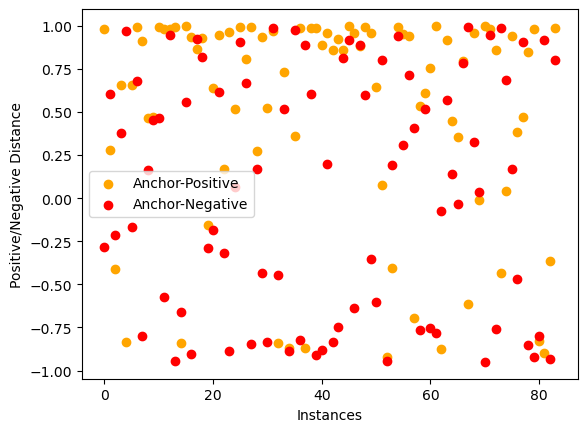

In [90]:
plot_distances(v_distance_measures, int(len(v_distance_measures)/128))

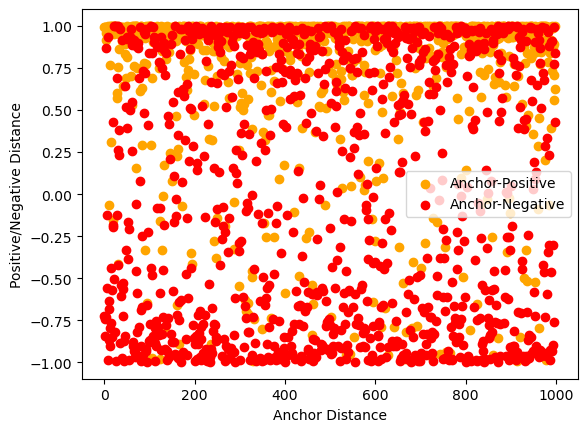

In [264]:
plot_distances(v_distance_measures, len(v_distance_measures))

Based on the inference code and the subsequent analysis, it's evident that the Siamese network model underwent learning as indicated by the distribution of distance values between positive and negative images. The plot of distances shows a considerable concentration of values on both the positive and negative sides, indicating that the model has learned to differentiate between similar and dissimilar instances to a significant extent.

However, the presence of overlap between the distances of positive and negative images suggests that the model's performance is not be optimal yet. This overlap indicates that there are a lot of instances where the model incorrectly classified positive and negative images, highlighting the need for further training.

Moreover, the observation of overfitting towards the end of training, indicated by the increase in loss and potential plateauing of performance, suggests that the current model architecture might not be sufficiently complex to capture the intricacies of the data. Therefore, to improve the model's performance and mitigate overfitting, it may be necessary to explore more complex architectures or adjust the training strategy.

In conclusion, while the Siamese network model demonstrated learning and the ability to differentiate between similar and dissimilar instances, further training with a more sophisticated architecture and careful consideration of training strategies are warranted to enhance performance and minimize overfitting.